# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [354]:
# Load the libraries as required.

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import warnings


In [316]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

fires_dt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [317]:
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)


In [318]:
print(f'X_train shape:\n {X_train.shape}')
print(f'Y_train shape:\n {Y_train.shape}')
print('--------' * 10)
print(f'X_test shape:\n {X_test.shape}')
print(f'Y_test shape:\n {Y_test.shape}')

X_train shape:
 (387, 12)
Y_train shape:
 (387,)
--------------------------------------------------------------------------------
X_test shape:
 (130, 12)
Y_test shape:
 (130,)


In [292]:
print(f'total of null: {X.isnull().sum().tolist()}')
Y_train



total of null: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


446    0.00
515    0.00
154    1.46
25     0.00
265    0.79
       ... 
71     0.00
106    0.00
270    0.52
435    0.00
102    0.00
Name: area, Length: 387, dtype: float64

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [293]:
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols = ['month', 'day']


preproc1 = ColumnTransformer(
    transformers=[
        ('scaling', RobustScaler(), num_cols),
        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist', drop = 'if_binary'), cat_cols)
    ],remainder='drop'
)

preproc1


ColumnTransformer(transformers=[('scaling', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('encoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [294]:
preproc2 = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('log', FunctionTransformer(lambda X: np.log1p(X))),  
            ('scaling', StandardScaler())  
        ]), num_cols),  
        ('categorical', OneHotEncoder(handle_unknown='infrequent_if_exist'), cat_cols)  
    ],
    remainder='drop' 
)


preproc2

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000142BC147940>)),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [305]:
# Pipeline A = preproc1 + baseline

# Suppress warnings
warnings.filterwarnings("ignore")

# Define pipeline
Pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', KNeighborsRegressor())
])


Pipeline_A


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaling', RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [306]:
# Pipeline B = preproc2 + baseline

# Suppress warnings
warnings.filterwarnings("ignore")

# Define pipeline
Pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', KNeighborsRegressor())
])

Pipeline_B


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000142BC147940>)),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [340]:
# Pipeline C = preproc1 + advanced model

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the pipeline with RandomForestClassifier
Pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

Pipeline_C


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaling', RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', HistGradientBoostingRegressor(random_state=42))])

In [341]:
# Pipeline D = preproc2 + advanced model

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the pipeline with RandomForestClassifier
Pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

Pipeline_D
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000142BC147940>)),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', HistGradientBoostingRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [369]:
# Pipeline A = preproc1 + baseline tuned

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the scoring metrics for evaluation
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))
}

# Define hyperparameter grid for KNeighborsRegressor
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 10],
    'regressor__weights': ['uniform', 'distance']
}

# Set up GridSearchCV to find the best hyperparameters for KNN regression
grid_cv = GridSearchCV(
    estimator=Pipeline_A,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    refit='neg_root_mean_squared_error'
)

# Fit the GridSearchCV to the training data
grid_cv.fit(X_train, Y_train)

# Evaluate cross-validation results
Pipeline_A_scoring_dict = cross_validate(grid_cv.best_estimator_, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)
Pipeline_A_scoring_dict_df = pd.DataFrame(Pipeline_A_scoring_dict)

# Convert results to a DataFrame
Pipeline_A_scoring_dict_df = pd.DataFrame(Pipeline_A_scoring_dict)

# Display mean scores
print("Pipeline A Mean Scores:")
print(Pipeline_A_scoring_dict_df.mean())
Pipeline_A_scoring_dict_df



Pipeline A Mean Scores:
fit_time                                0.007100
score_time                              0.007700
test_r2                                -0.612300
train_r2                                0.085459
test_neg_mean_squared_error         -2462.261953
train_neg_mean_squared_error        -2036.396150
test_neg_mean_absolute_error          -17.667070
train_neg_mean_absolute_error         -16.139978
test_neg_root_mean_squared_error      -43.515721
train_neg_root_mean_squared_error     -44.293603
dtype: float64


,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.007500,0.006000,-0.119404,0.075603,-1977.791774,-2149.623490,-19.469628,-15.980117,-44.472371,-46.364032
1,0.007000,0.010000,-2.368837,0.088683,-605.448560,-2476.023819,-14.995603,-17.853447,-24.605864,-49.759661
2,0.006498,0.007500,-0.297712,0.073208,-994.018436,-2384.773673,-17.309208,-16.664874,-31.528058,-48.834145
3,0.007500,0.008002,-0.040345,0.123830,-7965.507203,-739.561586,-23.530792,-12.386845,-89.249690,-27.194882
4,0.007000,0.007000,-0.235199,0.065970,-768.543793,-2431.998182,-13.030117,-17.814610,-27.722622,-49.315294


In [370]:
# Pipeline B = preproc2 + baseline tuned

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the scoring metrics for evaluation
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))
}


# Define hyperparameter grid for KNeighborsRegressor
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 10],
    'regressor__weights': ['uniform', 'distance']
}

# Set up GridSearchCV to find the best hyperparameters for KNN regression
grid_cv = GridSearchCV(
    estimator=Pipeline_B,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    refit='neg_root_mean_squared_error'
)

# Fit the GridSearchCV to the training data
grid_cv.fit(X_train, Y_train)


# Evaluate cross-validation results
Pipeline_B_scoring_dict = cross_validate(grid_cv.best_estimator_, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)
Pipeline_B_scoring_dict_df = pd.DataFrame(Pipeline_B_scoring_dict)

# Convert results to a DataFrame
Pipeline_B_scoring_dict_df = pd.DataFrame(Pipeline_B_scoring_dict)

# Display mean scores
print("Pipeline B Mean Scores:")
print(Pipeline_B_scoring_dict_df.mean())
Pipeline_B_scoring_dict_df



Pipeline B Mean Scores:
fit_time                                0.009201
score_time                              0.009699
test_r2                                -0.797325
train_r2                                0.085994
test_neg_mean_squared_error         -2482.413592
train_neg_mean_squared_error        -2029.899773
test_neg_mean_absolute_error          -17.979676
train_neg_mean_absolute_error         -16.160128
test_neg_root_mean_squared_error      -44.086934
train_neg_root_mean_squared_error     -44.247363
dtype: float64


,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.010000,0.010501,-0.041614,0.065241,-1840.350764,-2173.718456,-18.438577,-16.061586,-42.899310,-46.623154
1,0.012002,0.012498,-3.245915,0.100746,-763.077252,-2443.248233,-16.112333,-17.669369,-27.623853,-49.429224
2,0.011500,0.008997,-0.332873,0.067047,-1020.950269,-2400.627260,-17.178078,-16.256123,-31.952312,-48.996196
3,0.006003,0.008999,-0.039950,0.111855,-7962.479810,-749.669532,-24.102727,-12.787619,-89.232728,-27.380094
4,0.006501,0.007500,-0.326272,0.085082,-825.209865,-2382.235385,-14.066662,-18.025945,-28.726466,-48.808149


In [362]:
# Pipeline C = preproc1 + advanced model tuned

# Suppress warnings
warnings.filterwarnings("ignore")

# Define scoring metrics for evaluation
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))
}

# Define hyperparameter grid for Gradient Boosting
param_grid_boosting = {
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_iter': [100, 200],
    'regressor__max_depth': [None, 10, 20]
}

# Set up GridSearchCV for Gradient Boosting
grid_cv_boosting = GridSearchCV(
    estimator=Pipeline_C,
    param_grid=param_grid_boosting,
    scoring=scoring,
    cv=5,
    refit='neg_root_mean_squared_error'
)

# Fit the Gradient Boosting model to the training data
grid_cv_boosting.fit(X_train, Y_train)

# Evaluate cross-validation results
Pipeline_C_scoring_dict = cross_validate(grid_cv_boosting.best_estimator_, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)
Pipeline_C_scoring_dict_df = pd.DataFrame(Pipeline_C_scoring_dict)

# Print mean cross-validation scores
print("Boosting Pipeline C Mean Scores:")
print(Pipeline_C_scoring_dict_df.mean())
Pipeline_C_scoring_dict_df


Boosting Pipeline C Mean Scores:
fit_time                                0.126401
score_time                              0.010400
test_r2                                -0.133127
train_r2                                0.101926
test_neg_mean_squared_error         -2249.082161
train_neg_mean_squared_error        -2006.928732
test_neg_mean_absolute_error          -16.701404
train_neg_mean_absolute_error         -15.239269
test_neg_root_mean_squared_error      -40.247064
train_neg_root_mean_squared_error     -43.938274
dtype: float64


,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.122001,0.010499,-0.019241,0.078350,-1800.822102,-2143.235216,-18.356552,-14.701612,-42.436094,-46.295088
1,0.137499,0.009501,-0.444397,0.089835,-259.587468,-2472.893092,-12.398966,-17.364645,-16.111718,-49.728192
2,0.123501,0.010998,-0.067368,0.098767,-817.579984,-2319.007202,-16.059333,-15.295907,-28.593356,-48.156071
3,0.114502,0.010999,-0.000690,0.161125,-7661.883165,-708.081616,-23.055278,-12.185600,-87.532184,-26.609803
4,0.134500,0.010000,-0.133937,0.081552,-705.538085,-2391.426534,-13.636891,-16.648582,-26.561967,-48.902214


In [365]:
# Pipeline D = preproc2 + advanced model tuned

# Suppress warnings
warnings.filterwarnings("ignore")

# Define scoring metrics for evaluation, including RMSE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))
}

# Define hyperparameter grid for Gradient Boosting
param_grid_boosting = {
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_iter': [100, 200],
    'regressor__max_depth': [None, 10, 20]
}

# Set up GridSearchCV for Gradient Boosting
grid_cv_boosting = GridSearchCV(
    estimator=Pipeline_D,
    param_grid=param_grid_boosting,
    scoring=scoring,
    cv=5,
    refit='neg_root_mean_squared_error'
)

# Fit the Gradient Boosting model to the training data
grid_cv_boosting.fit(X_train, Y_train)

# Evaluate cross-validation results
Pipeline_D_scoring_dict = cross_validate(grid_cv_boosting.best_estimator_, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)
Pipeline_D_scoring_dict_df = pd.DataFrame(Pipeline_D_scoring_dict)

# Print mean cross-validation scores
print("Boosting Pipeline D Mean Scores:")
print(Pipeline_D_scoring_dict_df.mean())
Pipeline_D_scoring_dict_df


Boosting Pipeline D Mean Scores:
fit_time                                0.119499
score_time                              0.008700
test_r2                                -0.133160
train_r2                                0.101926
test_neg_mean_squared_error         -2249.088246
train_neg_mean_squared_error        -2006.928732
test_neg_mean_absolute_error          -16.701579
train_neg_mean_absolute_error         -15.239269
test_neg_root_mean_squared_error      -40.247253
train_neg_root_mean_squared_error     -43.938274
dtype: float64


,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.117499,0.008498,-0.019241,0.078350,-1800.822102,-2143.235216,-18.356552,-14.701612,-42.436094,-46.295088
1,0.109999,0.006999,-0.444566,0.089835,-259.617894,-2472.893092,-12.399841,-17.364645,-16.112663,-49.728192
2,0.119499,0.010999,-0.067368,0.098767,-817.579984,-2319.007202,-16.059333,-15.295907,-28.593356,-48.156071
3,0.121999,0.005502,-0.000690,0.161125,-7661.883165,-708.081616,-23.055278,-12.185600,-87.532184,-26.609803
4,0.128500,0.011502,-0.133937,0.081552,-705.538085,-2391.426534,-13.636891,-16.648582,-26.561967,-48.902214


# Evaluate

+ Which model has the best performance?

In [372]:
# Calculate mean results for each pipeline
mean_pipeline_a = Pipeline_A_scoring_dict_df.mean()
mean_pipeline_b = Pipeline_B_scoring_dict_df.mean()
mean_pipeline_c = Pipeline_C_scoring_dict_df.mean()
mean_pipeline_d = Pipeline_D_scoring_dict_df.mean()

# Combine into a single DataFrame
best_performance_df = pd.DataFrame({
    'Pipeline_A': mean_pipeline_a,
    'Pipeline_B': mean_pipeline_b,
    'Pipeline_C': mean_pipeline_c,
    'Pipeline_D': mean_pipeline_d
})

# Optional: Transpose for easier readability
best_performance_df = best_performance_df.T

# Rank by 'mean_neg_log_loss' in ascending order
best_performance_df = best_performance_df.sort_values(by='test_neg_root_mean_squared_error', ascending=False)

# Create a new column 'Rank' to rank pipelines based on mean_neg_log_loss
best_performance_df['Rank'] = range(1, len(best_performance_df) + 1)

# Display the ranked DataFrame
best_performance_df


,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,Rank
Pipeline_C,0.126401,0.010400,-0.133127,0.101926,-2249.082161,-2006.928732,-16.701404,-15.239269,-40.247064,-43.938274,1
Pipeline_D,0.119499,0.008700,-0.133160,0.101926,-2249.088246,-2006.928732,-16.701579,-15.239269,-40.247253,-43.938274,2
Pipeline_A,0.007100,0.007700,-0.612300,0.085459,-2462.261953,-2036.396150,-17.667070,-16.139978,-43.515721,-44.293603,3
Pipeline_B,0.009201,0.009699,-0.797325,0.085994,-2482.413592,-2029.899773,-17.979676,-16.160128,-44.086934,-44.247363,4


Following the results, Pipeline C is ranking first as it has the lower value for train_negative_root_mean_squared_error and test_neg_mean_root_squared_error, which was used to for ranking.

# Export

+ Save the best performing model to a pickle file.

In [416]:
# Export the DataFrame to a pickle file
best_performance_df.to_pickle('best_performance_df.pkl')

In [417]:

# Load the DataFrame from the pickle file
best_performance_df_pickle = pd.read_pickle('best_performance_df.pkl')
best_performance_df_pickle

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,Rank
Pipeline_C,0.126401,0.010400,-0.133127,0.101926,-2249.082161,-2006.928732,-16.701404,-15.239269,-40.247064,-43.938274,1
Pipeline_D,0.119499,0.008700,-0.133160,0.101926,-2249.088246,-2006.928732,-16.701579,-15.239269,-40.247253,-43.938274,2
Pipeline_A,0.007100,0.007700,-0.612300,0.085459,-2462.261953,-2036.396150,-17.667070,-16.139978,-43.515721,-44.293603,3
Pipeline_B,0.009201,0.009699,-0.797325,0.085994,-2482.413592,-2029.899773,-17.979676,-16.160128,-44.086934,-44.247363,4


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

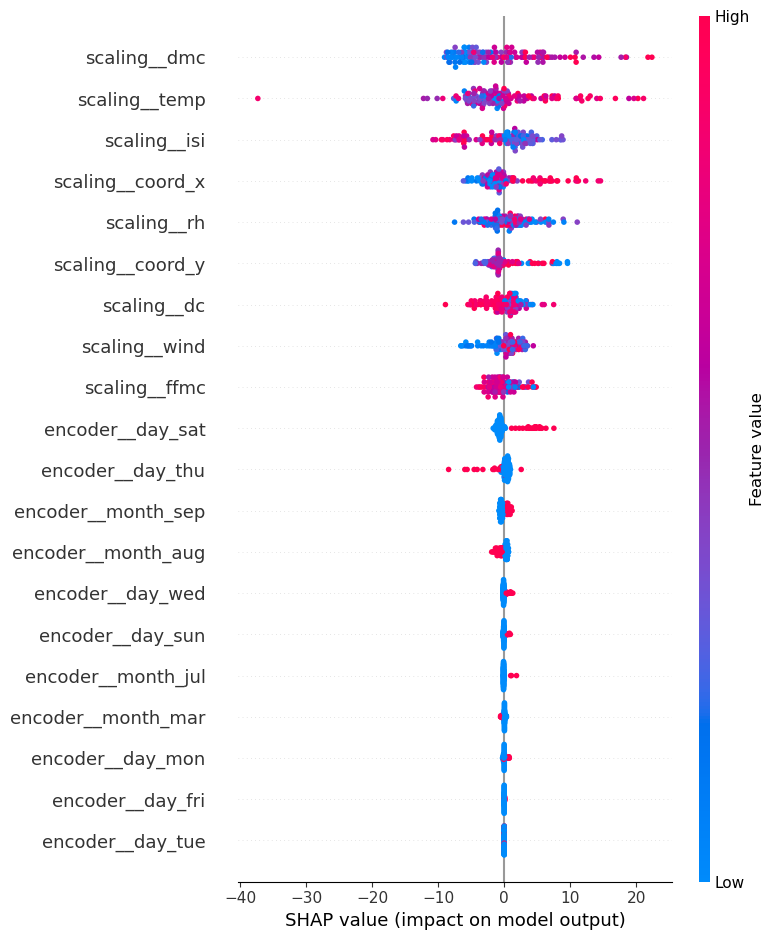

In [408]:
# Fit Pipeline_C
Pipeline_C.fit(X_train, Y_train)

# Transform X_test using the preprocessing step in the pipeline
data_transform = Pipeline_C.named_steps['preprocessing'].transform(X_test)

# Initialize TreeExplainer for the HistGradientBoostingRegressor
explainer = shap.TreeExplainer(Pipeline_C.named_steps['regressor'])

# Get SHAP values
shap_values = explainer.shap_values(data_transform)

# Get feature names from the preprocessing step
feature_names = Pipeline_C.named_steps['preprocessing'].get_feature_names_out()

# Summary plot
shap.summary_plot(shap_values, features=data_transform, feature_names=feature_names)


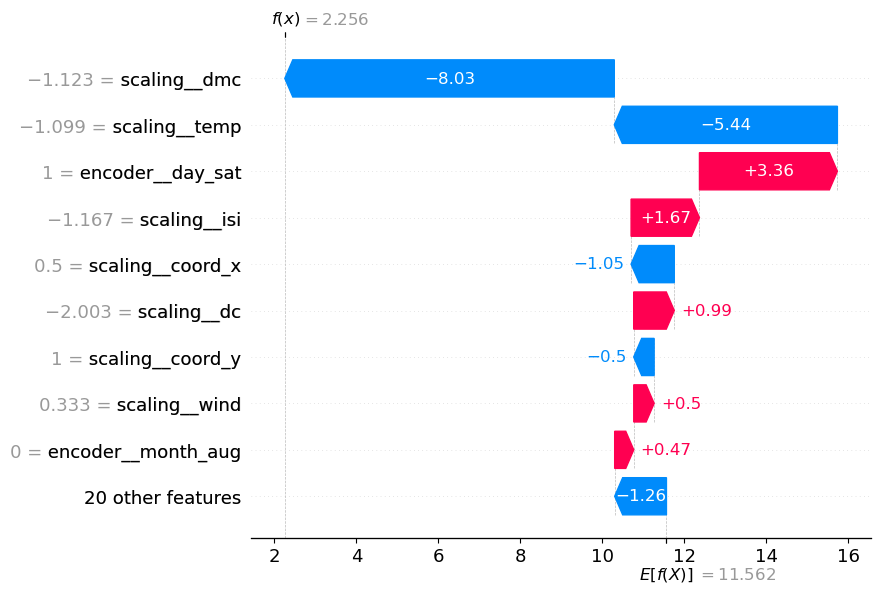

In [415]:

instance_index = 0
explanation = shap.Explanation(values=shap_values[instance_index], 
                                feature_names=feature_names, 
                                base_values=explainer.expected_value, 
                                data=data_transform[instance_index])


shap.plots.waterfall(explanation)


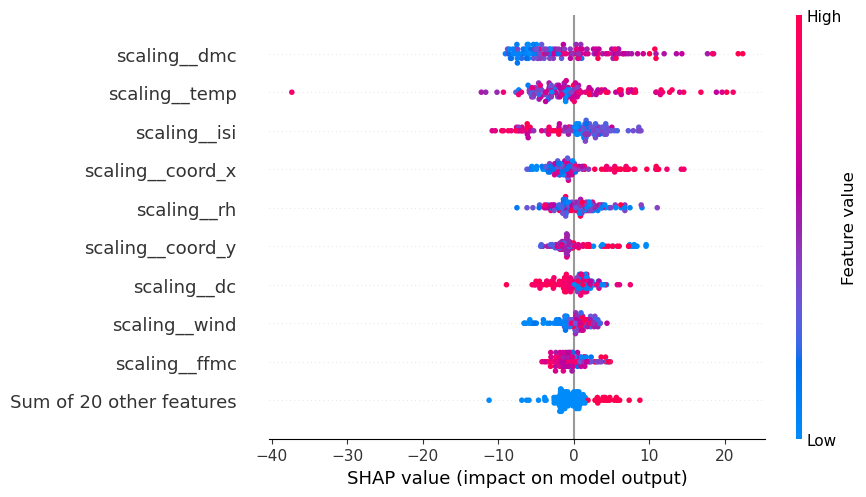

In [411]:
explanation = shap.Explanation(values=shap_values, 
                                feature_names=feature_names, 
                                base_values=explainer.expected_value, 
                                data=data_transform)

shap.plots.beeswarm(explanation)

*(Answer here.)*

Looking at the SHAP plots, we can see that the most influential features for our predictions are dmc, temp, isi, coord_x, rh, and coord_y. These features really drive the model's decisions and have a significant impact on the outcomes. On the other hand, it seems that the features like month and day don't contribute much to our predictions; they are among the least important.

If I were to streamline the model by removing features, I'd consider dropping month and day. Since they don't seem to enhance the model's performance, this could help simplify the model and possibly improve its efficiency. To confirm that these features are truly unnecessary, I would test the model's performance without them and compare the results with the original model. This way, I can ensure that we're not losing any important predictive power by making these changes.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.